In [30]:
# from torchvision import transforms
from bindsnet.analysis.plotting import plot_spikes
# from bindsnet.datasets import MNIST
# from bindsnet.encoding import PoissonEncoder
import torch


def pixel_poisson(datum: torch.Tensor, time, seed=0) -> torch.Tensor:
    """
    Generates Poisson-distributed interval trains. datum must be 1D Tensor non-negative, and
    give the firing rate in Hz.
    """
    output = torch.zeros(time, *datum.shape)
    temp_dic = {}
    for i, x in enumerate(datum):
        item = x.item()
        if item in temp_dic:
            output[:, i] = temp_dic[item]
            continue
        torch.manual_seed(seed)
        dist = torch.distributions.Poisson(rate=x)
        single_train = dist.sample(sample_shape=torch.Size([time]))
        temp_dic[item] = single_train
        output[:, i] = single_train
    return output


def conv_poisson(datum: torch.Tensor, time: int, dt: float = 1.0, kernel_size=3, reverse=False,**kwargs) -> torch.Tensor:
    # language=rst
    """
    Generates Poisson-distributed spike trains based on input intensity. Inputs must be
    non-negative, and give the firing rate in Hz. Inter-spike intervals (ISIs) for
    non-negative data incremented by one to avoid zero intervals while maintaining ISI
    distributions.

    :param datum: Tensor of shape ``[n_1, ..., n_k]``.
    :param time: Length of Poisson spike train per input variable.
    :param dt: Simulation time step.
    :return: Tensor of shape ``[time, n_1, ..., n_k]`` of Poisson-distributed spikes.
    """
    assert (datum >= 0).all(), "Inputs must be non-negative"
    assert (datum.dtype is torch.float)

    func = torch.nn.MaxPool2d(
        kernel_size=kernel_size,
        stride=kernel_size,)

    max_3x3_datum = func(datum)
    # mask = datum / max_3x3_datum.repeat_interleave(kernel_size, 1) \
    #                             .repeat_interleave(kernel_size, 2)
    # mask = (mask * time).long()

    shape1, size = max_3x3_datum.shape, max_3x3_datum.numel()
    max_3x3_datum = max_3x3_datum.flatten()
    time = int(time / dt)
    intervals = pixel_poisson(max_3x3_datum, time+1)
    intervals[:, max_3x3_datum != 0] += (intervals[:, max_3x3_datum != 0] == 0).float()

    times = torch.cumsum(intervals, dim=0).long()
    times[times >= time + 1] = 0

    spikes = torch.zeros(time + 1, *max_3x3_datum.shape).byte()
    spikes[times, torch.arange(size)] = 1
    spikes = spikes[1:].view(time, *shape1) \
                       .repeat_interleave(kernel_size, 2) \
                       .repeat_interleave(kernel_size, 3)

    padding_num = datum.shape[-1] - spikes.shape[-1]
    if padding_num > 0:
        pad_func = torch.nn.ZeroPad2d(padding=(0, padding_num, 0, padding_num))
        spikes = pad_func(spikes)
    # ones = torch.ones(time, *shape)
    # mask_sum = torch.cumsum(dim = 0)
    # spikes[spikes==mask]
    indices = spikes.cumsum(dim=0).long()
    spikes[indices > datum.view(1, *datum.shape).repeat(time, *[1 for _ in range(datum.ndim)])] = 0

    if not reverse:
        indices = list(range(time))
        indices.reverse()
        return spikes[indices]

    return spikes

tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12., 13., 14., 15., 16.],
         [17., 18., 19., 20., 21., 22., 23., 24.],
         [25., 26., 27., 28., 29., 30., 31., 32.],
         [33., 34., 35., 36., 37., 38., 39., 40.],
         [41., 42., 43., 44., 45., 46., 47., 48.],
         [49., 50., 51., 52., 53., 54., 55., 56.],
         [57., 58., 59., 60., 61., 62., 63., 64.]]])


([<matplotlib.collections.PathCollection at 0x7fd15b3d7f10>],
 [<AxesSubplot:title={'center':'input_spikes spikes for neurons (0 - 64) from t = 0 to 500 '}, xlabel='Simulation time', ylabel='Neuron index'>])

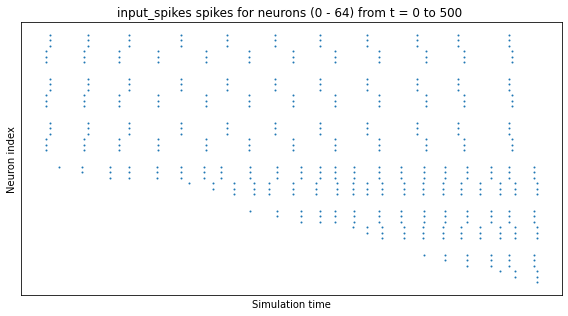

In [31]:
time = 500
test = torch.arange(1, 65).reshape(1, 8, 8).float()
print(test)
input_spikes_train = conv_poisson(test, time)
plot_spikes({"input_spikes": input_spikes_train})